In [81]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# Analyizing Rainfall near Lake Chad  

This tutorial is focused on solving the problem of determining **when** the rainy season starts and ends over Lake Chad.
[Future notebooks in this series]() deal with analyzing the Lake Chad region *before* and *after* the rainy season to determine how much the rainy season contributes to the surface area of Lake Chad. 
    

### What to expect from this notebook

- Introduction to precipitation data.
- Exposure to datacube
- Exposure to `xarrays`
- Visualizing time series data 
- curve fitting to determine start and end dates of the rainy season. 

### Algorithmic process

1. create Datacube object
2. define boundaries of study area
3. use boudaries to load data 
4. create a time series representation of data
5. curve fit to find rainy season start and end





# Creating the datacube object 


The following code connects to the datacube and accepts `chad_rainfall` as an app-name.

In [98]:
import datacube
dc = datacube.Datacube(app = "chad_rainfall", config = '/home/localuser/.datacube.conf') 

This object is the main interface to your stored and ingested data. It can handle complicated things like reprojecting data with varying resolutions and orientations. It can also be used to explore existing datasets. In this tutorial, it is only used for loading data from the datacube

##  Loading GPM data

A small dataset is easier to work with than the entirety of Lake Chad. The region you're about to load contains GPM measurements for a small area of Lake Chad near the mouth of its largest contributing river. The code below displays the bounds of the region but doesn't load it. 
  

In [83]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = (12.75, 13.0),longitude = (14.25, 14.5))  


## Setting boundaries of our load  


In [84]:
## Define Geographic boundaries using a (min,max) tuple.
latitude = (12.75, 13.0)
longitude = (14.25, 14.5)

## Specify a date range using a (min,max) tuple  
from datetime import datetime
time = (datetime(2015,1,1), datetime(2016,1,2))

## define the name you gave your data while it was being "ingested", as well as the platform it was captured on. 
product = 'gpm_imerg_gis_daily_global'
platform = 'GPM'  

<br>  

It's simple to intuit what the **latitude**,**longitude** and **time** bounds will get you. It will give you a bounded and grided-dataset containing our rainy season. Each square in the diagram below represents the smallest spatial unit in our imagery. This smallest unit is often reffered to as a **pixel**.
  
<br>  

![img](diagrams/rainy_demo/rainy2.png)


While defining space and time bounds are simple to understand, it may be more complicated to pick up on what **product** and **platform** are. Platform will tell you how/where the data is produced. Product is a key used to chose what representation of that platform's data you wish to index.  

For the sake of this tutorial, think of **product** and **platform** as shorthand names we used to look up data that is:  

- produced on a **GPM** platform.
  
- represented using **gpm_imerg_gis_daily_global** settings or types.
   
The representation reflects personal prefferences that define, for example, the resolution of each pixel, how pixels are sampled, and the sort of geometric projections this grid of pixels undergoes to assume its current shape. Scripts for adding more general product types/representations are avaiable [here](), but aren't necessary to understanding this stage of the tutorial.  

## Loading the data  

In [85]:
#Load Percipitation data using parameters,
gpm_data = dc.load(latitude = latitude, longitude = longitude, time = time, product = product, platform = platform)

##  Exploring precipitation data  


The code above should have loaded an [xarray]() containing your GPM data.  An xarray data-structure is essentially a wrapper for high-dimensional data-arrays. One of its main uses is the coupling of different data with a shared set of coordinates.
  
Conceptually, you can imagine GPM's xarray looking like this:  

<br>

![img](diagrams/rainy_demo/gpm_01.png)  
  
<br>

Each latitude-longitude coordinate pair will have,  `total_precipitation`, `liquid_precipitation`, `ice_precipitation` and `percent_liquid` measurements taken for them.  

An Xarray Dataset will store each of these measurements in separate grids and share a single set of coordinates among all measurements.  

To get some detailed information about an xarray, a `print()` statement will give you a readout on its structure.  
<br>

In [99]:
print( gpm_data )

<xarray.Dataset>
Dimensions:               (latitude: 3, longitude: 3, time: 366)
Coordinates:
  * time                  (time) datetime64[ns] 2015-01-01T11:59:59.500000 ...
  * latitude              (latitude) float64 12.95 12.85 12.75
  * longitude             (longitude) float64 14.25 14.35 14.45
Data variables:
    total_precipitation   (time, latitude, longitude) int32 0 0 0 0 0 0 0 0 ...
    liquid_precipitation  (time, latitude, longitude) int32 0 0 0 0 0 0 0 0 ...
    ice_precipitation     (time, latitude, longitude) int32 0 0 0 0 0 0 0 0 ...
    percent_liquid        (time, latitude, longitude) uint8 15 15 15 15 15 ...
Attributes:
    crs:      EPSG:4326


<br>
Using the readout above we can quickly gain a summary of the dataset we just loaded by examining:  

- **Coordinates**  
a readout of individual coordinates. In this case, it's three lists of `latitude`, `longitude`, and `time` values
- **Dimensions**  
a readout of how large each dimension is. In this case, we've loaded in a 3 by 3 area of land have 295 acquisitions between 2014-2015. This can hint that this is a daily, not hourly or monthly precipitation product.   
- **Data Variables**  
a readout of what sort of data is stored. In this case, each `latitude`, `longitude`, and `time` point will store four types of data. One for each `total_precipitation`, `liquid_precipitation`, `ice_precipitation`,`percent_liquid` variable.  

- **Data Size**  
Each entry has a size/type associated.  IE. `int32`, `int8`, `float64`.  You can use this to manage the memory footprint of your object. 



# Computing the daily average of precipitation

The xarray that you're using has several built-in functions to efficiently run large scale operations on all points within the xarray. The following code makes use of one of those built-in functions to determine the average precipitation in an area for each time slice

In [87]:
mean_precipitation = gpm_data.mean(dim = ['latitude', 'longitude'])

The code above will: 
-  take the average of all measurements in latitude rows and store them in a **time * longitude** coordinate pair. 
-  take the average of all measurements in longitude `longitude` rows and store them in a **time** coordinate. 

The diagram below should detail the operations of averaging these areas.  

![img](diagrams/rainy_demo/mean123.png) 




Our new xarray dataset will retain a single dimension called time. Each point in time will store a value representing the average of all pixel values at that time.  
  
Take a look at the print statement below.  

In [88]:
print(mean_precipitation)

<xarray.Dataset>
Dimensions:               (time: 366)
Coordinates:
  * time                  (time) datetime64[ns] 2015-01-01T11:59:59.500000 ...
Data variables:
    total_precipitation   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    liquid_precipitation  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    ice_precipitation     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    percent_liquid        (time) float64 15.0 15.0 15.0 15.0 15.0 15.0 15.0 ...


Things you should notice:  

- We're still representing mean_values using an xarray  

- only time is displayed under the **coordinates** section.     
  **latitude** and **longitude** are essentially dropped.  
  
- The averaging operation was performed on all datasets; `total_precipitation`, `liquid_precipitation`,`ice_precipitation`, and `percent_liquid`

# Displaying time series data

Xarray Datasets store several [data-arrays](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html).  

The code below neatly extracts a **total_precipitation** data-array from our **mean_precipitation** Dataset.  
<br>   

In [89]:
mean_total_precipitation = mean_precipitation.total_precipitation  

<br>  
The new representation is also an xarray data-structure. When printed it looks something like this.  
<br>  

In [100]:
print(mean_total_precipitation)

<xarray.DataArray 'total_precipitation' (time: 366)>
array([ 0.,  0.,  0., ...,  0.,  0.,  0.])
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01T11:59:59.500000 ...


<br>
For time series plotting we care about extracting **time** coordinates, and the data-array **values**  
<br>

In [91]:
times = mean_total_precipitation.time.values
values = mean_total_precipitation.values

<br>  
The next line of code plots a time series graph of our values  
<br>  

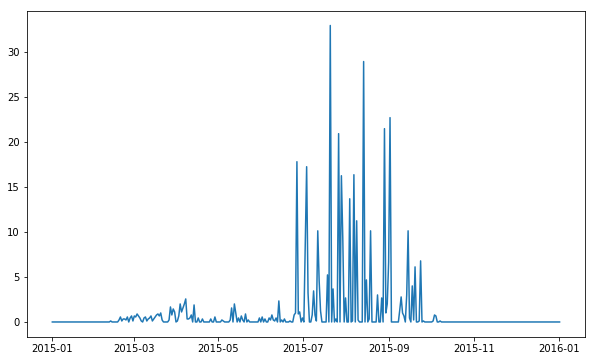

In [101]:
import matplotlib.pyplot as plt
plt.plot(times, values) 

# Determining the bounds of the rainy season  
  
The section above displayed daily precipitation values observed in 2015.  
The shape would fit a bell curve very well.   The following code deals with fitting a bell curve to our time series.  
<br>  
  

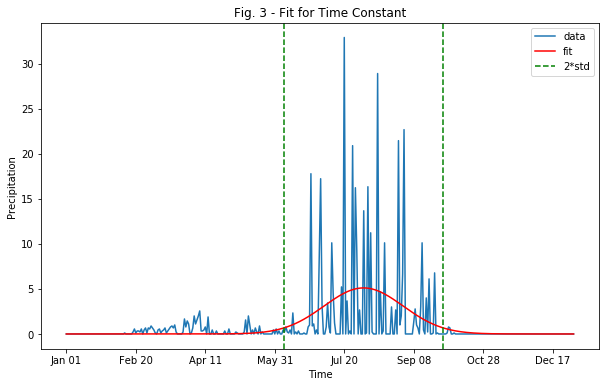

In [102]:
#Code for this algorithm is out of scope for this tutorial on datacube and is abstracted away for demonstration purposes. 
import demo.curve_fit_gaussian as curve_fit

curve_fit.plot_fit(times, values, standard_deviations = 2)  

<br>  
We pick two points that are equidistant from the center/peak of this curve to act as our bounding points for the rainy season.  
<br>  

In [95]:
curve_fit.get_bounds(times, values, standard_deviations = 2)

(numpy.datetime64('2015-09-28T11:59:59.500000000'),
 numpy.datetime64('2015-06-06T11:59:59.500000000'))

It appears that **JUNE** and **OCTOBER** should be adequate bounds for the rainy season.    

# Next Steps  

This notebook served as an introduction to datacube and the xarray datasets. Now that we have the extent of our rainy season you can proceed with the [next notebook](igarrs_chad_02.ipynb), in wich landsat07 data is broken into a pre and post rainy season dataset and cleaned up in preparation for [water detection](igarrs_chad_03.ipynb). The entire notebook has been condensed down to a about a dozen lines of code below.     

In [104]:
from datetime import datetime
import demo.curve_fit_gaussian as curve_fit

latitude = (12.75, 13.0)
longitude = (14.25, 14.5)
time = (datetime(2015,1,1), datetime(2016,1,2))
product = 'gpm_imerg_gis_daily_global'
platform = 'GPM'  
gpm_data = dc.load(latitude = latitude, longitude = longitude, time = time, product = product, platform = platform)

mean_precipitation = gpm_data.mean(dim = ['latitude', 'longitude'])

times =  mean_precipitation.time.values
values = mean_precipitation.total_precipitation.values  
  
curve_fit.get_bounds(times, values, standard_deviations = 3)

(numpy.datetime64('2015-10-27T11:59:59.500000000'),
 numpy.datetime64('2015-05-09T11:59:59.500000000'))